# Proximal Policy Optimization (PPO) for Stock Trading

PPO can be effectively used for stock trading by training an agent to make optimal trading decisions in a simulated environment. The agent learns to maximize returns while managing risks by interacting with the market data through a reinforcement learning framework. The key is to carefully design the environment, reward structure, and training process to reflect real-world trading dynamics and ensure robust, generalizable performance.

### Imports

In [1]:
# Data Preprocessing
import pandas as pd
import datetime
import yfinance as yf
from ta.volume import VolumeWeightedAveragePrice

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

C:\Users\andre\anaconda3\envs\env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Data Preprocessing

In [2]:
# Data Extraction
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1825)

symbol = "SPY"
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.drop(columns=["Adj Close"], inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-08-12,289.959991,291.609985,287.019989,288.070007,65527600
2019-08-13,287.739990,294.149994,287.359985,292.549988,94299800
2019-08-14,288.070007,288.739990,283.760010,283.899994,135622100
2019-08-15,284.880005,285.640015,282.390015,284.649994,99556600
2019-08-16,286.480011,289.329987,284.709991,288.850006,83018300


In [4]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], 
                                  volume=df["Volume"], window=14, fillna=False)
df["VWAP"] = vwap.volume_weighted_average_price()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,VWAP
Date,,,,,,
2019-08-29,291.720001,293.160004,290.609985,292.579987,57899400,288.391013
2019-08-30,294.220001,294.239990,291.420013,292.450012,62901200,288.609749
2019-09-03,290.570007,291.579987,289.269989,290.739990,69101400,288.491125
2019-09-04,293.140015,294.059998,292.309998,294.040009,46887300,289.152156
2019-09-05,296.790009,298.829987,294.000000,297.820007,83258100,290.336693


In [5]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100
df_mod = df_mod / df_mod.max()
df_mod = df_mod.dropna()
df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod.head()

,Open,High,Low,Close,Volume,VWAP,Close_Price
0,0.134982,0.058677,0.039148,-0.004903,0.044497,0.043407,292.450012
1,-0.195399,-0.143992,-0.103621,-0.064537,0.050772,-0.023523,290.739990
2,0.139311,0.135473,0.147603,0.125276,-0.165583,0.131134,294.040009
3,0.196119,0.258368,0.081202,0.141887,0.399551,0.234449,297.820007
4,0.073237,-0.003730,0.163382,0.008523,-0.208324,0.129817,298.049988


In [6]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:650]
df_test = df_mod.copy()
df_test = df_test.iloc[650:]

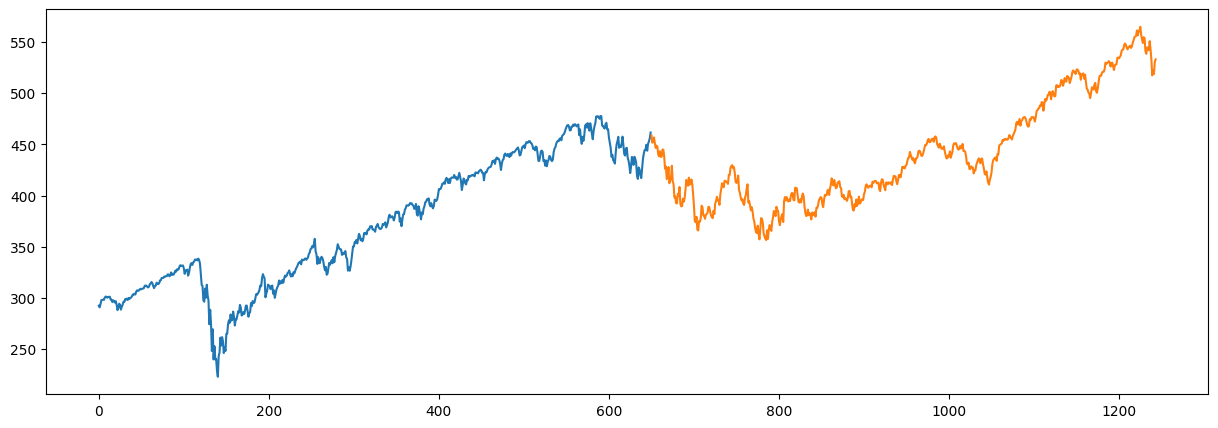

In [7]:
# View price behaviour
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot(label = 'Training Data')
df_test["Close_Price"].plot(label = 'Testing Data')
plt.show()

This plot shows the training data in the blue followed by the testing data in orange.

### Environment

In [8]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation


# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7, ), dtype=np.float32)

    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
        
    # Structure sign observation data
    def _next_observation(self):
        
        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()       
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "VWAP"].item()
        
        env_4 = 1 if self.long_short_ratio else 0
        
        obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])
        
        return obs

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()
    
        self.current_step += 1
        
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False
        
        obs = self._next_observation()

        return obs, reward, done, {}

    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

We define a custom OpenAI Gym environment, StockTradingEnv, for simulating stock trading. The environment models a stock trading scenario where an agent can take actions (going long, short, or holding) based on market data observations (such as stock prices, volume, and VWAP). The agent starts with an initial balance and aims to maximize its profit through trading while considering trading costs and maintaining a balance of long and short trades. The reward function encourages profitable trading while penalizing volatility and extreme long-short imbalances. The environment tracks trading performance over a series of time steps and resets at the start of a new episode.

In [9]:
# Test Environment
env = StockTradingEnv(df_train)
actions = [0, 1, 2]  # Actions: Long, Hold, Short
observation = env.reset()
print("Initial Observation: ", observation)

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received: ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Long/Short Ratio: ", env.long_short_ratio)  # Adjusted to use long_short_ratio
    print("-------------------")

Initial Observation:  [-0.09836551 -0.02138457  0.10664506  0.05118759 -0.20108187 -0.00540594
  0.        ]

Action Taken:  0
Reward Received:  -0.014067269319778999
Next State:  [ 0.0941943   0.04871253 -0.13859048 -0.13128368  0.36470666 -0.0771293
  1.        ]
Completed:  False
-------------------
Available Balance:  998.8105270377813
Realized Profit:  -1.1894729622186517
Long/Short Ratio:  1.0
-------------------

Action Taken:  1
Reward Received:  0.011977349526630956
Next State:  [-0.33010224 -0.37089847 -0.30486768 -0.19496745  0.20019566 -0.26493047
  1.        ]
Completed:  False
-------------------
Available Balance:  999.3854216198439
Realized Profit:  0.5748945820626301
Long/Short Ratio:  0.5
-------------------

Action Taken:  2
Reward Received:  0.011955157683838799
Next State:  [-0.19938378 -0.05791738 -0.0891783   0.09042492 -0.15662081 -0.18335404
  1.        ]
Completed:  False
-------------------
Available Balance:  999.3854216198439
Realized Profit:  0.57489458206

This test demonstrates the basic functionality of the trading environment, showing how the agent's actions influence its balance, profit, and trading metrics. The code also highlights how rewards are calculated based on the net profit relative to market volatility and trade strategy balance.

Results Analysis:

Initial Observation: The initial state of the environment shows normalized market data features, such as the stock's high, low, close prices, and trading volume.
First Action (0 - Go Long): The agent goes long, and while the net profit increases slightly, the reward is negative, suggesting that the profit didn't adequately compensate for the volatility. The long/short ratio becomes 1.0, indicating the agent has only taken long positions so far.
Second Action (1 - Go Short): The agent takes a short position, receiving a positive reward and a significant increase in profit, which suggests the market moved in a way that favored the short position. The long/short ratio adjusts to 0.5, reflecting a more balanced trading strategy.
Third Action (2 - Hold): The agent holds its position, and while the reward remains positive, the balance and profit stay the same since no new trades were executed. The long/short ratio remains at 0.5.

In [10]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

PPOMemory Class:

This class stores the experiences (states, actions, probabilities, values, rewards, and done flags) during training.
It provides a method generate_batches() to shuffle and split the stored experiences into batches for training.
It also includes methods to store new experiences (store_memory) and clear memory after each training cycle (clear_memory).

In [11]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

ActorNetwork Class:

This is the neural network responsible for deciding the actions the agent should take. It outputs a probability distribution over possible actions using a softmax layer.
The network consists of two fully connected layers followed by ReLU activations.
It uses an AdamW optimizer for training and includes methods to save and load the model's weights.

In [12]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

CriticNetwork Class:

The critic network estimates the value function, which predicts the expected cumulative reward (value) of a state.
Similar to the actor network, it has two fully connected layers and uses ReLU activations.
It also uses an AdamW optimizer and includes methods to save and load its weights.

In [13]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

Agent Class:

This class encapsulates the PPO agent, which combines the actor and critic networks along with the memory.
Key methods include:
choose_action: Takes an observation from the environment and uses the actor network to sample an action and the critic network to estimate the value of the state.
learn: This is where the PPO algorithm's learning happens. It computes advantages, calculates the actor and critic losses, and performs backpropagation to update the networks. It iterates through multiple epochs and batches for stability and efficient learning.
remember: Stores the agent's experiences in memory.
save_models and load_models: Save and load the weights of the actor and critic networks.

### Key Aspects of the PPO Algorithm:
Advantage Calculation: The advantage function is computed to determine how much better an action was compared to the expected value. This helps in adjusting the policy towards better actions.
Clipped Objective: PPO uses a clipped objective function to prevent too large updates to the policy, ensuring stable and controlled learning.
Actor-Critic Framework: The agent is based on an actor-critic framework where the actor decides the actions, and the critic evaluates them.

In [14]:
# Initialize the environment
env = StockTradingEnv(df_train)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [-0.09836551 -0.02138457  0.10664506  0.05118759 -0.20108187 -0.00540594
  0.        ]
Number of Actions:  2
Action Chosen:  0
Probability of Action:  -0.6892780065536499
Value of Action:  0.08224751055240631
Next Oberservation [ 0.0941943   0.04871253 -0.13859048 -0.13128368  0.36470666 -0.0771293
  1.        ]
Reward -0.014067269319778999
Done False
Info {}


The agent is interacting with the stock trading environment, making decisions based on the observations and its learned policy. In this particular step, the agent chose to "Short" the stock, but the outcome was a small loss, reflected by the negative reward. The negative values for action probability and state value suggest that the agent might have encountered a challenging state where profitable actions were not clear or likely.

... starting ...
... saving models ...
episode: 0, score: -31.703900900607053, avg score: -31.703900900607053, best_score: -31.703900900607053
episode: 1, score: -38.89388316883492, avg score: -35.298892034720986, best_score: -31.703900900607053
... saving models ...
episode: 2, score: 54.96391353513135, avg score: -5.211290178103542, best_score: -5.211290178103542
episode: 3, score: -65.29338982906056, avg score: -20.231815090842794, best_score: -5.211290178103542
episode: 4, score: 16.093152199138252, avg score: -12.966821632846585, best_score: -5.211290178103542
episode: 5, score: -20.136198604907932, avg score: -14.161717794856811, best_score: -5.211290178103542
episode: 6, score: -26.842142400638153, avg score: -15.973207024254146, best_score: -5.211290178103542
episode: 7, score: -12.44870283436257, avg score: -15.532644000517697, best_score: -5.211290178103542
episode: 8, score: -8.625289318550397, avg score: -14.765160146965776, best_score: -5.211290178103542
episode: 9, score:

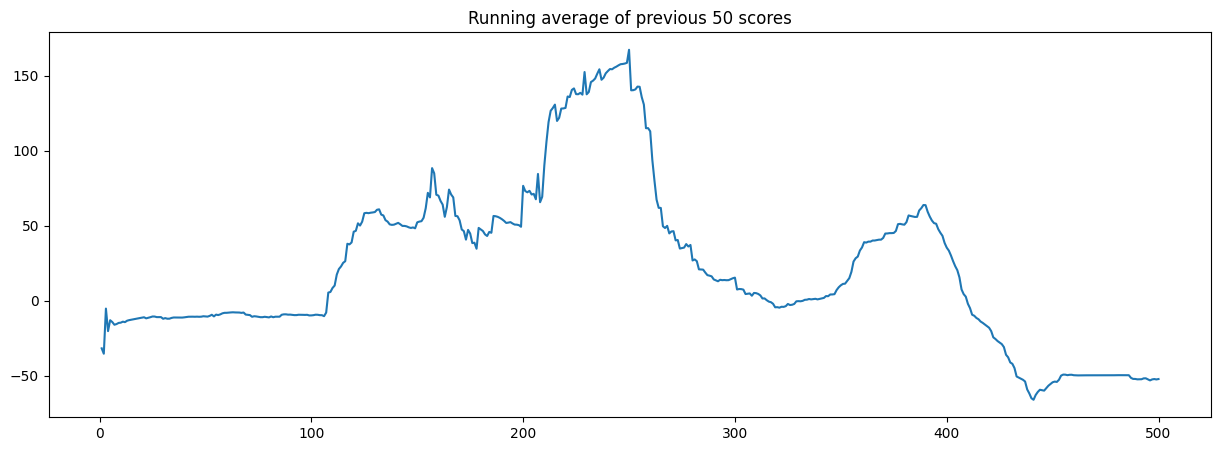

In [15]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)
    plt.show()

if __name__ == '__main__':
    env = StockTradingEnv(df_train)
    N = 20
    batch_size = 5
    n_epochs = 3
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape)

    n_games = 500

    figure_file = 'stock_training.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
            observation = observation_
            
        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])
        
        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()
        
        print(f"episode: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")
            
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

Next we train the Proximal Policy Optimization (PPO) agent to trade stocks using a custom StockTradingEnv environment. The agent interacts with the environment over multiple episodes (n_games = 500), where in each episode, it takes actions based on the current state, receives rewards, and stores these experiences in memory. Every N = 20 steps, the agent updates its policy by learning from the collected experiences.

The training loop tracks the cumulative reward (score) for each episode, and periodically evaluates the agent's performance by calculating the average score over the last 50 episodes. If this average score improves, the agent's model is saved. Finally, we plot the running average of the scores over time, allowing us to visualize the agent's learning progress across episodes.

### Load Model

In [16]:
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [17]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(5, len(reporting_df)):

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "VWAP"].item()
    
    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])
    
    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()
    
    print(np.argmax(probs), probs)
    
    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

0 [0.6637843  0.33621567]
1 [0.30903625 0.69096375]
0 [0.95825815 0.04174187]
0 [0.98834354 0.01165649]
0 [0.5662375  0.43376252]
1 [0.31883436 0.68116564]
0 [0.5418016 0.4581984]
0 [0.7192399  0.28076008]
0 [0.9325538  0.06744611]
1 [0.2541903 0.7458097]
1 [0.4355611  0.56443894]
0 [0.9905998  0.00940015]
1 [0.33942118 0.66057885]
0 [0.7014744  0.29852557]
0 [0.73375845 0.26624158]
0 [0.5024488  0.49755117]
0 [0.96388745 0.03611257]
1 [0.44354758 0.55645245]
1 [0.31911013 0.6808899 ]
0 [0.99711275 0.00288723]
0 [0.9016494  0.09835053]
0 [0.5617884 0.4382116]
0 [0.5636079  0.43639216]
0 [0.80070215 0.19929789]
0 [9.9998903e-01 1.0938247e-05]
1 [0.48151627 0.51848376]
0 [0.96939045 0.03060957]
0 [0.649748   0.35025197]
0 [0.8039241  0.19607592]
1 [0.4006249 0.5993751]
0 [0.7285059  0.27149412]
0 [0.80136985 0.19863021]
1 [0.40907347 0.5909266 ]
0 [0.9124227  0.08757729]
0 [0.5792 0.4208]
0 [0.98735    0.01265001]
0 [0.5648405  0.43515947]
0 [0.5335004 0.4664997]
0 [0.5575786 0.4424214]


In [18]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[5:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)
        
df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,-0.288220,446.519989,-0.009999,0.663784,0.336216,0.663784,1.000000,0.990001
1,-0.045820,448.769989,0.005039,0.309036,0.690964,-0.690964,1.003345,0.995040
2,0.084129,447.570007,-0.002674,0.958258,0.041742,0.958258,1.005199,0.992366
3,-0.135719,439.920013,-0.017092,0.988344,0.011656,0.988344,0.988735,0.975273
4,-0.036530,438.290009,-0.003705,0.566238,0.433763,0.566238,0.985114,0.971568
...,...,...,...,...,...,...,...,...
584,-0.708821,517.380005,-0.029124,0.337972,0.662028,-0.662028,1.230146,1.174021
585,0.233348,522.150024,0.009220,0.606890,0.393109,0.606890,1.222638,1.183240
586,0.280603,518.659973,-0.006684,0.915195,0.084806,0.915195,1.217678,1.176556
587,-0.135908,530.650024,0.023117,0.369960,0.630040,-0.630040,1.243441,1.199674


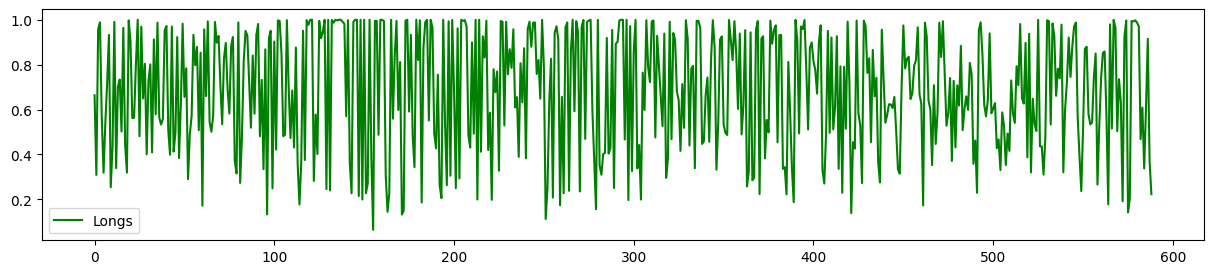

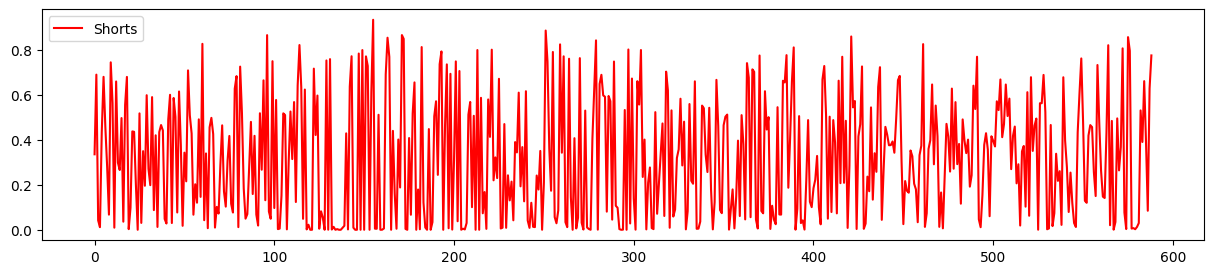

In [19]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")
plt.show()

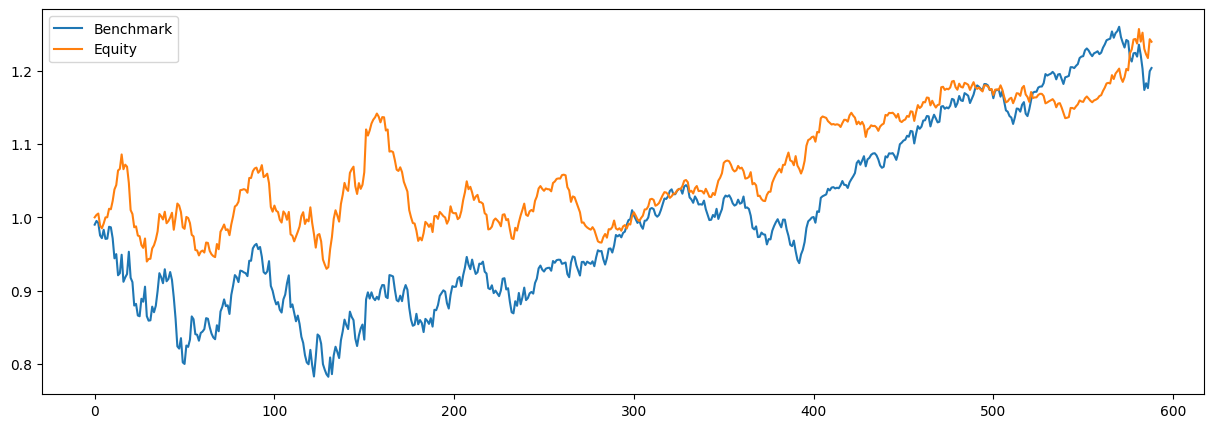

In [20]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()
plt.show()

We can see the PPO agent does beat the buy-and-hold strategy at time 

In [21]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return 19.37%
ROI at 24.0%


### References 

https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)

Machine Learning Applied to Stock & Crypto Trading, Shaun McDonogh, https://www.https://www.udemy.com/course/machine-learning-applied-to-stock-crypto-trading-python